In [1]:
!rm housing.csv
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-16 16:20:00--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.05s   

2023-10-16 16:20:00 (28.6 MB/s) - ‘housing.csv’ saved [1423529/1423529]



#### Dependencies

In [2]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text

from tqdm import tqdm
import xgboost as xgb

#### Load Data

In [3]:
data = pd.read_csv("housing.csv")

#### Prepare data

In [4]:
# keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df = data.copy()[data["ocean_proximity"].isin(["<1H OCEAN", "INLAND"])]
print(f"Rows: {df.shape[0]:,}")
print(f"Cols: {df.shape[1]}")

Rows: 15,687
Cols: 10


In [5]:
# fill nas with mean
df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].mean())

In [6]:
# Apply the log tranform to median_house_value
df["log_median_house_value"] = np.log1p(df["median_house_value"])

In [7]:
# Do train/validation/test split with 60%/20%/20% distribution.
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df.drop(["log_median_house_value", "median_house_value"], axis=1),
    df["log_median_house_value"],
    test_size=0.2,
    random_state=1
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    random_state=1
)

In [8]:
# Use DictVectorizer(sparse=True) to turn the dataframe into matrices.
dv = DictVectorizer(sparse=True)
X_train_dv = dv.fit_transform(X_train.to_dict(orient="records"))
X_val_dv = dv.transform(X_val.to_dict(orient="records"))
 

#### Question 1

In [9]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train_dv, y_train)

DecisionTreeRegressor(max_depth=1)

In [10]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



#### Question 2

In [11]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train_dv, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [12]:
y_pred = rf.predict(X_val_dv)
mean_squared_error(
    y_true=y_val,
    y_pred=y_pred,
    squared=False
)

0.23955880901853752

#### Question 3

In [13]:
rmse_1 = []
n_estimators_values = range(10, 210, 10)

for n_estimators in tqdm(n_estimators_values, total=len(n_estimators_values)):
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        random_state=1,
        n_jobs=-1
    )

    rf.fit(X_train_dv, y_train)

    rmse_1.append(
        mean_squared_error(
            y_true=y_val,
            y_pred=rf.predict(X_val_dv),
            squared=False
        )
    )

100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


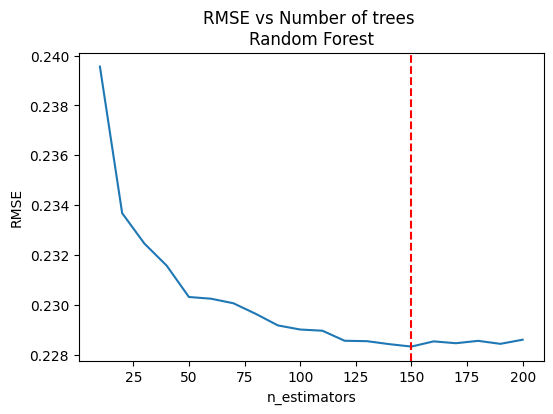

In [14]:
plt.figure(figsize=(6, 4))
plt.plot(n_estimators_values, rmse_1)
plt.ylabel("RMSE")
plt.xlabel("n_estimators")
plt.title("RMSE vs Number of trees \nRandom Forest")
plt.axvline(list(n_estimators_values)[np.argmin(rmse_1)], color="red", linestyle="--")
plt.show()

#### Question 4 

In [15]:
max_depth_values = {depth: [] for depth in [10, 15, 20, 25]}

for max_depth in max_depth_values:
    for n_estimators in tqdm(n_estimators_values, total=len(n_estimators_values)):
        rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=1,
            n_jobs=-1
        )

        rf.fit(X_train_dv, y_train)

        max_depth_values[max_depth].append(
            mean_squared_error(
                y_true=y_val,
                y_pred=rf.predict(X_val_dv),
                squared=False
            )
        )

100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


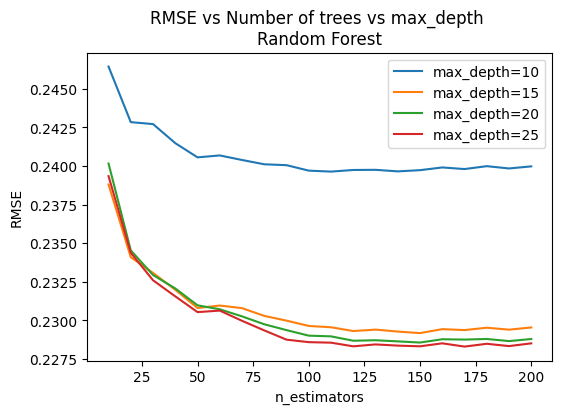

In [16]:
plt.figure(figsize=(6, 4))
for max_depth in max_depth_values:
    plt.plot(n_estimators_values, max_depth_values[max_depth], label=f"max_depth={max_depth}")
plt.ylabel("RMSE")
plt.xlabel("n_estimators")
plt.title("RMSE vs Number of trees vs max_depth \nRandom Forest")
plt.legend()
plt.show()

#### Question 5

In [17]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train_dv, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

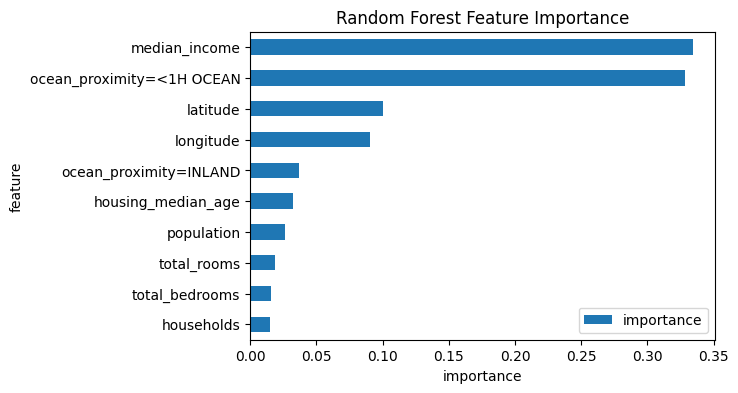

In [18]:
pd.DataFrame(
    zip(dv.get_feature_names_out(), rf.feature_importances_),
    columns=["feature", "importance"]
).sort_values(by="importance", ascending=True) \
.set_index("feature") \
.plot(kind="barh", figsize=(6, 4), title="Random Forest Feature Importance")
plt.xlabel("importance")
plt.show()

#### Question 6

In [19]:
dtrain = xgb.DMatrix(X_train_dv, label=y_train, feature_names=[c.replace("<", "_less_") for c in dv.get_feature_names_out().tolist()])
dval = xgb.DMatrix(X_val_dv, label=y_val, feature_names=[c.replace("<", "_less_") for c in dv.get_feature_names_out().tolist()])

/home/jjmov99/mlzoomcamp/.venv/lib/python3.10/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


In [20]:
watchlist = [(dtrain, "train"), (dval, "val")]

#### eta 0.3

In [21]:
xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "nthread": 24,

    "seed": 1,
    "verbosity": 1,
}

In [22]:
evals_result = {}
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=watchlist,
    evals_result=evals_result,
    verbose_eval=10
)

[0]	train-rmse:0.44304	val-rmse:0.44359


[10]	train-rmse:0.21625	val-rmse:0.24544
[20]	train-rmse:0.19213	val-rmse:0.23596
[30]	train-rmse:0.17439	val-rmse:0.23076
[40]	train-rmse:0.16357	val-rmse:0.22669
[50]	train-rmse:0.15365	val-rmse:0.22423
[60]	train-rmse:0.14409	val-rmse:0.22320
[70]	train-rmse:0.13633	val-rmse:0.22146
[80]	train-rmse:0.12848	val-rmse:0.22038
[90]	train-rmse:0.12184	val-rmse:0.21989
[99]	train-rmse:0.11648	val-rmse:0.21983


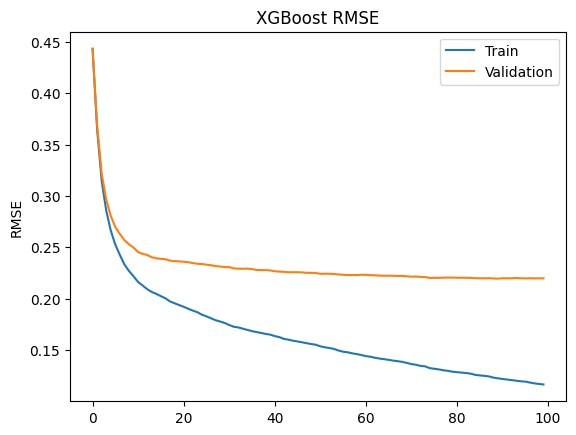

In [23]:
epochs = len(evals_result['train']['rmse'])
x_axis = range(0, epochs)
plt.plot(x_axis, evals_result['train']['rmse'], label='Train')
plt.plot(x_axis, evals_result['val']['rmse'], label='Validation')
plt.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [24]:
mean_squared_error(
    y_true=y_val,
    y_pred=xgb_model.predict(dval),
    squared=False
)

0.2198299076679932

#### eta 0.1

In [25]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "nthread": 24,

    "seed": 1,
    "verbosity": 1,
}

In [26]:
evals_result = {}
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=watchlist,
    evals_result=evals_result,
    verbose_eval=10,
)

[0]	train-rmse:0.52380	val-rmse:0.52215
[10]	train-rmse:0.30436	val-rmse:0.31317
[20]	train-rmse:0.24705	val-rmse:0.26512
[30]	train-rmse:0.22107	val-rmse:0.24727
[40]	train-rmse:0.20437	val-rmse:0.23735
[50]	train-rmse:0.19416	val-rmse:0.23155
[60]	train-rmse:0.18659	val-rmse:0.22896
[70]	train-rmse:0.17969	val-rmse:0.22615
[80]	train-rmse:0.17306	val-rmse:0.22466
[90]	train-rmse:0.16872	val-rmse:0.22305
[99]	train-rmse:0.16394	val-rmse:0.22170


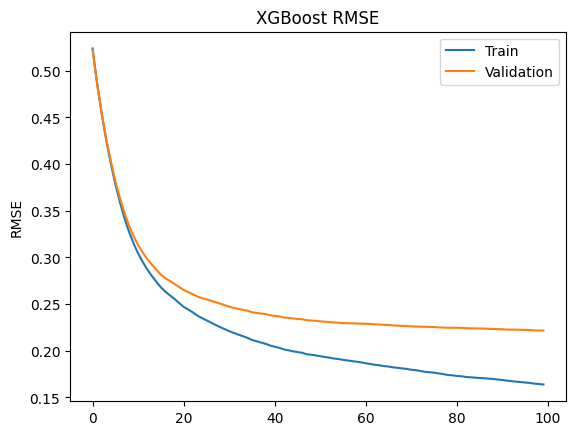

In [27]:
epochs = len(evals_result['train']['rmse'])
x_axis = range(0, epochs)
plt.plot(x_axis, evals_result['train']['rmse'], label='Train')
plt.plot(x_axis, evals_result['val']['rmse'], label='Validation')
plt.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [28]:
mean_squared_error(
    y_true=y_val,
    y_pred=xgb_model.predict(dval),
    squared=False
)

0.2216996476525723